In [100]:
#Import libraries
import numpy as np
import pandas as pd
import cv2
import os
from random import shuffle
from tqdm import tqdm
import scipy
import skimage
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
print('Successfully loaded libraries')

Successfully loaded libraries


<h3> Load in and Preprocess Image data </h3>

In [4]:
print(os.listdir('chest_xray/chest_xray'))

['.DS_Store', 'test', 'train', 'val']


In [5]:
print(os.listdir('chest_xray/chest_xray/train/'))

['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [6]:
#Create our train and test directories
train_dir = 'chest_xray/chest_xray/train/'
test_dir = 'chest_xray/chest_xray/test/'

Need to get the labels for the x-ray images

In [22]:
def preprocess_images(direc):
    #Store pictures into X and Y arrays that will later be broke into training and testing sets
    X = []
    y = []
    
    for next_d in os.listdir(direc):
        if not next_d.startswith('.'):
            if next_d in ['NORMAL']:
                label = 0
            elif next_d in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    
            temp = direc + next_d
        
            for img_file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + img_file)
                #If image exists resize it and append it to the X and Y array
                if img is not None:
                    img = skimage.transform.resize(img, (64,64,3)) #target size (64,64,3) for tensors and generators later on
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [23]:
#Load in data
train_X, train_y = preprocess_images(train_dir)

100%|██████████| 1342/1342 [17:47<00:00,  1.26it/s]


In [24]:
test_X, test_y = preprocess_images(test_dir)

100%|██████████| 234/234 [03:39<00:00,  1.07it/s]


(LEFT) Pneumonia Positive vs. (RIGHT) Normal
--------------------------------------------------------------------------


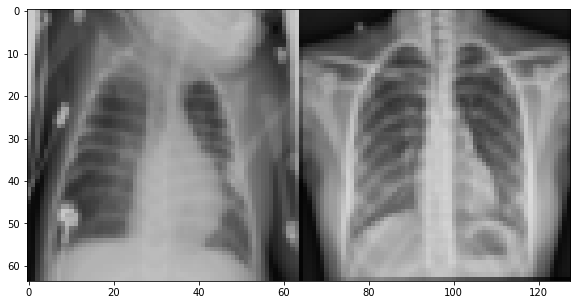

In [130]:
Pneu_imgs = os.listdir(train_dir + 'PNEUMONIA')
Norm_imgs = os.listdir(train_dir + 'NORMAL')

def img_plotter(i):
    img_gen_pneu = cv2.imread(train_dir + 'PNEUMONIA/' + Pneu_imgs[i])
    img_gen_pneu = skimage.transform.resize(img_gen_pneu, (64,64,3), mode = 'reflect')
    img_gen_norm = cv2.imread(train_dir + 'NORMAL/' + Norm_imgs[i])
    img_gen_norm = skimage.transform.resize(img_gen_norm, (64,64,3))
    #Pair the images together
    pairing = np.concatenate((img_gen_pneu, img_gen_norm), axis = 1)
    
    print('(LEFT) Pneumonia Positive vs. (RIGHT) Normal')
    print('--------------------------------------------------------------------------')
    plt.figure(figsize = (10,5))
    plt.imshow(pairing)
    plt.plot()

for i in range(0,1):
    img_plotter(i)

In [35]:
#Convert y train and test to categorical values
from keras.utils.np_utils import to_categorical
y_train = to_categorical(train_y, 2)
y_test = to_categorical(test_y, 2)

Using TensorFlow backend.


<h3> Will model accuracy be enough to tell us how well our model does in pneumonia prediction? </h3>

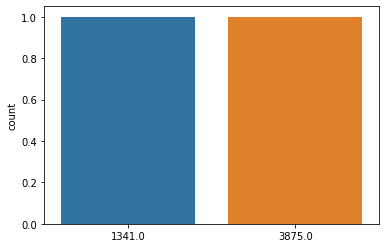

In [37]:
import seaborn as sns
count = y_train.sum(axis = 0)
sns.countplot(x = count)

<h3> Part below used IF model accuracy told us enough about pneumonia prediction, however we need to construct a confusion matrix to better assess model with precision and recall because of the imbalance in our dataset </h3>

Precision - the ability of the classification model to identify only the relevant data points.

Recall - model’s ability to find all the data points of interest in a dataset. 

Using ImageDataGenerator which It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images
into batches of tensors = helpful when training the network.

In [2]:
#Get training and test data for X-ray images (note images come in different file types
#training_set_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, width_shift_range = 0.2,
#                                          height_shift_range = 0.2, horizontal_flip = True)
#testing_set_datagen = ImageDataGenerator(rescale = 1./255)
#Validation image data generator for after model is run
#valid_set_datagen = ImageDataGenerator(rescale = 1./255)

Used rescale above to make the values of images between 0 and 1 since our neural network prefers small input values

In [3]:
#Create training and validation generators
#batch_size = 32
#training_gen = training_set_datagen.flow_from_directory('chest_xray/train', target_size = (64,64), batch_size = batch_size, class_mode = 'binary')
#validation_gen = testing_set_datagen.flow_from_directory('chest_xray/test', target_size = (64,64), batch_size = batch_size, class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<h3> Visualize training images </h3>

Get a batch of images

In [32]:
#sample_training_images, _ = next(training_gen)

Using Matplotlib we can nicely plot the images, for now we will leave labels out

In [33]:
#def display_samples(images_arr):
 #   fig, axes = plt.subplots(1, 5, figsize = (10,10))
  #  axes = axes.flatten()
   # for img, ax in zip(images_arr, axes):
   #     ax.imshow(img)
   #     ax.axis('off')
    #plt.tight_layout()
    #plt.show()

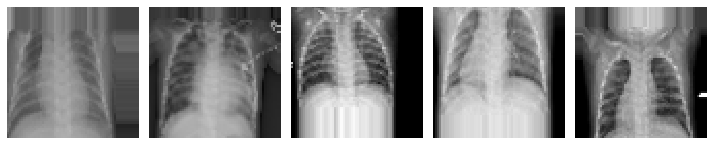

In [34]:
#display_samples(sample_training_images[:5])

<h3> Confirm shape(s) before plugging into our model </h3>

In [125]:
print(train_X.shape)

(5216, 64, 64, 3)


In [126]:
print(test_X.shape)

(624, 64, 64, 3)


<h3> Build model </h3>

In [114]:
#Building model with convolutional filters
model = Sequential([Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = (64,64,3)),
                   Conv2D(16, (3,3), padding = 'valid', activation = 'relu'),
                   MaxPooling2D(pool_size = (2,2)),
                   #Dropout(0.1),
                   Conv2D(32, (3,3), padding = 'same', activation = 'relu'),
                   Conv2D(32, (3,3), padding = 'valid', activation = 'relu'),
                   MaxPooling2D(pool_size = (2,2)),
                   Conv2D(64, (3,3), dilation_rate = (2,2), padding = 'same', activation = 'relu'),
                   Conv2D(64, (3,3), dilation_rate = (2,2), padding  = 'valid', activation = 'relu'),
                   Conv2D(128, (3,3), padding = 'valid', activation = 'relu'),
                   MaxPooling2D(pool_size = (2,2)),
                   Flatten(),
                   Dense(128, activation = 'relu'),
                   Dropout(0.3),
                   Dense(2, activation = 'sigmoid')])

#Dilation rate delivers a wider field of view at the same computational cost.

<h3> Compile model with optimizer and loss function </h3>

In [115]:
model.compile(optimizer = RMSprop(lr = 0.00005),
             loss = BinaryCrossentropy(),
             metrics = ['accuracy'])

<h3> Get a model summary </h3>

In [116]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 62, 62, 16)        2320      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 31, 31, 32)        4640      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 64)      

<h3> Train the model </h3>

In [117]:
epochs = 15
#Steps per epoch is set to default which is number of samples / batch size
result = model.fit(train_X, y_train, epochs = epochs, validation_data = (test_X, y_test))

Train on 5216 samples, validate on 624 samples
Epoch 1/15
5216/5216 [==============================] - 17s 3ms/sample - loss: 0.5749 - accuracy: 0.7428 - val_loss: 0.6519 - val_accuracy: 0.6250
Epoch 2/15
5216/5216 [==============================] - 15s 3ms/sample - loss: 0.5049 - accuracy: 0.7489 - val_loss: 0.5770 - val_accuracy: 0.6354
Epoch 3/15
5216/5216 [==============================] - 15s 3ms/sample - loss: 0.3849 - accuracy: 0.8221 - val_loss: 0.4632 - val_accuracy: 0.7853
Epoch 4/15
5216/5216 [==============================] - 15s 3ms/sample - loss: 0.3320 - accuracy: 0.8525 - val_loss: 0.4170 - val_accuracy: 0.8277
Epoch 5/15
5216/5216 [==============================] - 14s 3ms/sample - loss: 0.3055 - accuracy: 0.8669 - val_loss: 0.5173 - val_accuracy: 0.7660
Epoch 6/15
5216/5216 [==============================] - 15s 3ms/sample - loss: 0.2763 - accuracy: 0.8789 - val_loss: 0.4456 - val_accuracy: 0.8101
Epoch 7/15
5216/5216 [==============================] - 15s 3ms/sample 

<h3> Plot train and validation loss </h3>

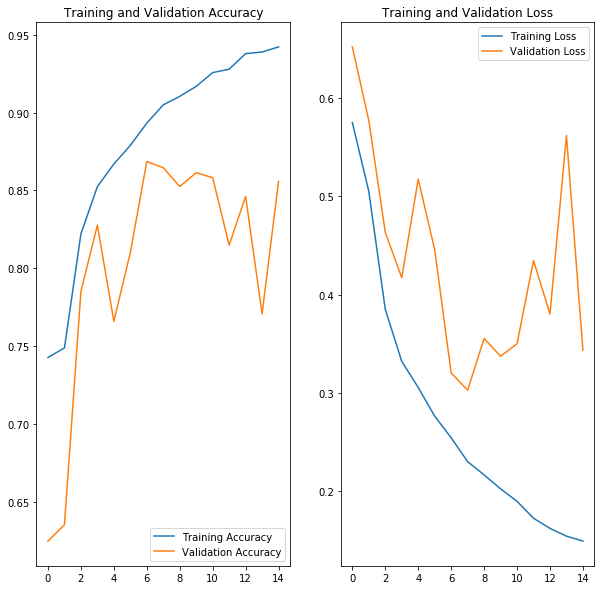

In [118]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epoch_x_range = np.arange(epochs)

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(epoch_x_range, acc, label = 'Training Accuracy')
plt.plot(epoch_x_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_x_range, loss, label = 'Training Loss')
plt.plot(epoch_x_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3> Save the model for later use </h3>

In [119]:
tf.keras.models.save_model(model, 'pneumonia_cnn', include_optimizer = True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: pneumonia_cnn/assets


<h3> Let's create a confusion matrix in order to get recall and precision </h3>

In [67]:
#Import necessary libraries
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [120]:
predict = model.predict(test_X)
predict = np.argmax(predict, axis = 1)
y_true = np.argmax(y_test, axis = 1)

<h3> Make sure our model is "predicting" i.e. We want a matrix of 1s and 0s </h3>

In [121]:
print(predict)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a93e7d358>)

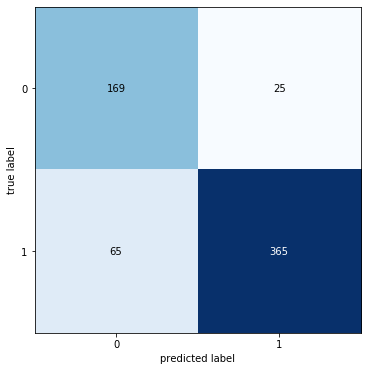

In [122]:
c_matrix = confusion_matrix(predict, y_true)
plot_confusion_matrix(c_matrix, figsize = (6,6))

<h3> Precision </h3>

number of true positives divided by the number of true positives plus the number of false positives

In [123]:
365 / (365 + 25)

0.9358974358974359

<h3> Recall </h3>

number of true positives divided by the number of true positives plus the number of false negatives

In [124]:
365 / (365 + 65)

0.8488372093023255

<h3> We have a nice blend of precision (~94%) and recall (~85%) here however, being a disease classification problem we would rather have a higher recall and sacrifice precision if the cost of follow-up exam is not significant </h3>